In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import preprocess_data

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/Spotify_train_dataset.csv')

features_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms', 'time_signature']

label = 'genre'

In [3]:
from sklearn.preprocessing import LabelEncoder

df_normal = preprocess_data(df, features_columns, z_score=False, standardize=False)
print(f"Shape dataframe original :{df_normal.shape}")

le = LabelEncoder()
df_label_encoded = le.fit_transform(df[label])

df_normal_standardized = preprocess_data(df, features_columns, standardize=True)
print(f"Shape dataframe original standardized without outliers :{df_normal_standardized.shape}")

------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (31728, 20)
------------------------------------------
Extract inputs ...
------------------------------------------
Data shape after preprocessing : (31728, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original :(31728, 13)
------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (31728, 20)
------------------------------------------
Extract inputs ...
Center and reduce inputs ...
------------------------------------------
Data shape after preprocessing : (31728, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original standardized without outliers :(31728, 13)


In [4]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


def compute_score_depth(X, y, depth_list):
    scores = np.zeros(shape=len(depth_list))
    kfold = KFold(n_splits=10, random_state=5)

    for i, depth in enumerate(depth_list):

        tree = RandomForestClassifier(max_depth=depth, random_state=5)
        y_pred = cross_val_predict(tree, X, y, cv=kfold)

        recall = recall_score(y, y_pred, average='micro')
        precision = precision_score(y, y_pred, average='micro')

        f_score = 2 * (precision * recall) / (precision + recall)

        scores[i] = f_score

    return scores

def make_classification_report(X, y, class_names, clf):
    kfold = KFold(n_splits=10, random_state=5)
    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    cf_matrix = confusion_matrix(y, y_pred)

    fig, ax = plt.subplots(figsize=(15,15))

    sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='hot_r')
    plt.show()

    return classification_report(y, y_pred, target_names=class_names)

def plot_scores_vs_depth(depth_list, score_list, title):
    plt.plot(depth_list, score_list, label='F1-Score vs depth')
    plt.xlabel('Depth')
    plt.suptitle(title)
    plt.grid()
    plt.show()


In [5]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_train_resample, X_test_base, y_train_resample, y_test_base = train_test_split(df_normal_standardized, df_label_encoded, random_state=5, test_size=0.33)

df_resample, labels_resample = oversample.fit_resample(X_train_resample, y_train_resample)

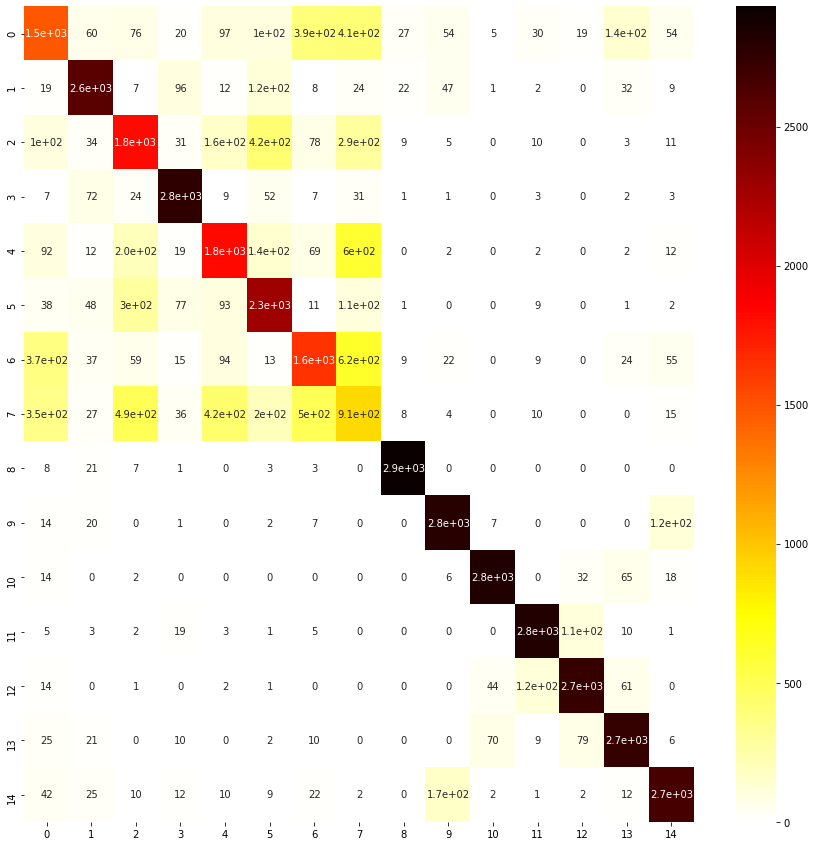

                 precision    recall  f1-score   support

      Dark Trap       0.58      0.50      0.54      2975
            Emo       0.87      0.87      0.87      2975
         Hiphop       0.61      0.61      0.61      2975
            Pop       0.89      0.93      0.91      2975
            Rap       0.67      0.61      0.64      2975
            RnB       0.68      0.77      0.72      2975
     Trap Metal       0.60      0.55      0.57      2975
Underground Rap       0.30      0.31      0.30      2975
            dnb       0.97      0.99      0.98      2975
      hardstyle       0.90      0.94      0.92      2975
      psytrance       0.96      0.95      0.96      2975
      techhouse       0.93      0.95      0.94      2975
         techno       0.92      0.92      0.92      2975
         trance       0.89      0.92      0.90      2975
           trap       0.90      0.89      0.90      2975

       accuracy                           0.78     44625
      macro avg       0.78   

In [6]:
clf = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=25)

print(make_classification_report(df_resample, labels_resample, le.classes_, clf))

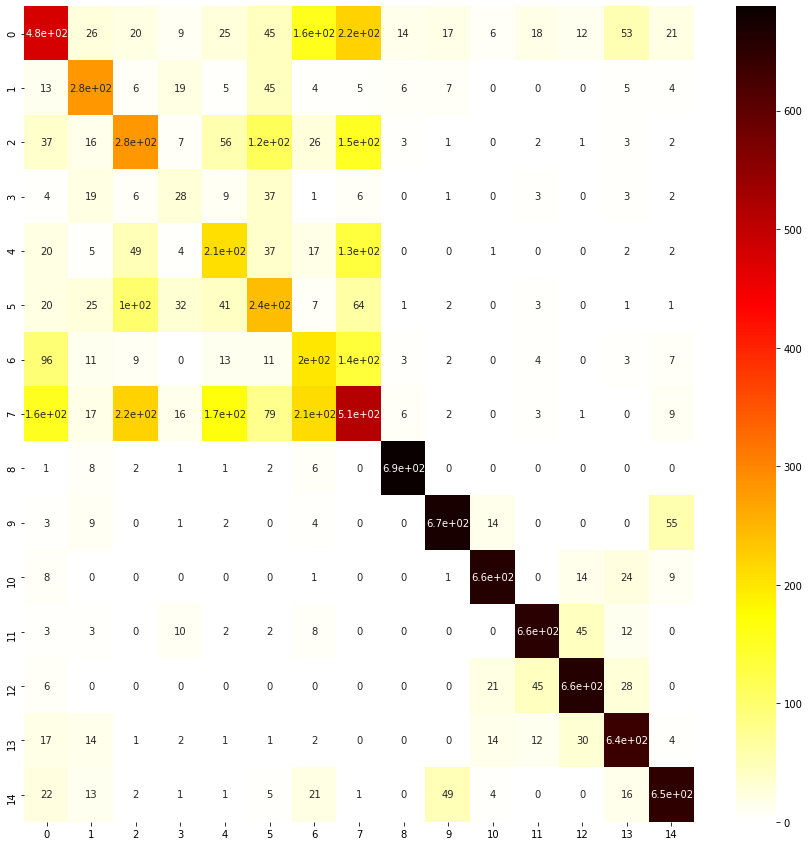

              precision    recall  f1-score   support

           0       0.54      0.43      0.48      1124
           1       0.63      0.70      0.66       401
           2       0.40      0.40      0.40       701
           3       0.22      0.24      0.22       119
           4       0.39      0.44      0.41       480
           5       0.39      0.45      0.42       541
           6       0.30      0.40      0.35       497
           7       0.42      0.36      0.39      1403
           8       0.95      0.97      0.96       709
           9       0.89      0.88      0.89       761
          10       0.92      0.92      0.92       717
          11       0.88      0.89      0.88       740
          12       0.86      0.87      0.87       759
          13       0.81      0.87      0.84       735
          14       0.85      0.83      0.84       784

    accuracy                           0.65     10471
   macro avg       0.63      0.64      0.63     10471
weighted avg       0.66   

In [9]:
clf.fit(df_resample, labels_resample)

y_pred_original = clf.predict(X_test_base)

cf_matrix = confusion_matrix(y_test_base, y_pred_original)

fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='hot_r')
plt.show()

print(classification_report(y_test_base, y_pred_original))